In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil.parser import parse
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
import unicodedata
import geopandas

from matplotlib import pyplot as plt

In [2]:
my_df= pd.read_pickle('cancer_data_cleaned.pkl')

my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7556 entries, 3254875 to 1195415
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   Rank              7556 non-null   int64    
 1   Title             7556 non-null   object   
 2   Status            7556 non-null   int64    
 3   Study Results     7556 non-null   object   
 4   Conditions        7556 non-null   object   
 5   Interventions     7556 non-null   object   
 6   Outcome Measures  7556 non-null   object   
 7   Gender            7556 non-null   float64  
 8   Age               7556 non-null   object   
 9   Phases            7556 non-null   object   
 10  Enrollment        7556 non-null   float64  
 11  Start Date        7556 non-null   period[M]
 12  Completion Date   7556 non-null   period[M]
 13  Locations         7556 non-null   object   
 14  URL               7556 non-null   object   
 15  Actual            7556 non-null   float64  
 1

In [3]:
X= my_df[['EFraction','Intervention', 'Months' , 'Age_Type', 'Gender' ]]

In [5]:
y=my_df['Status']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [7]:
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (5062, 5) (5062,)
Test (2494, 5) (2494,)


In [8]:
logmodel= LogisticRegression(class_weight='balanced')
logmodel.fit(X_train, y_train)
predictions_log= logmodel.predict(X_test)

In [9]:
print(classification_report(y_test, predictions_log))

              precision    recall  f1-score   support

           0       0.48      0.75      0.59       516
           1       0.92      0.79      0.85      1978

    accuracy                           0.78      2494
   macro avg       0.70      0.77      0.72      2494
weighted avg       0.83      0.78      0.80      2494



In [10]:
importance= logmodel.coef_.flatten()
importance

array([ 3.15371288,  0.05064296,  0.00790605,  0.05192451, -0.0527134 ])

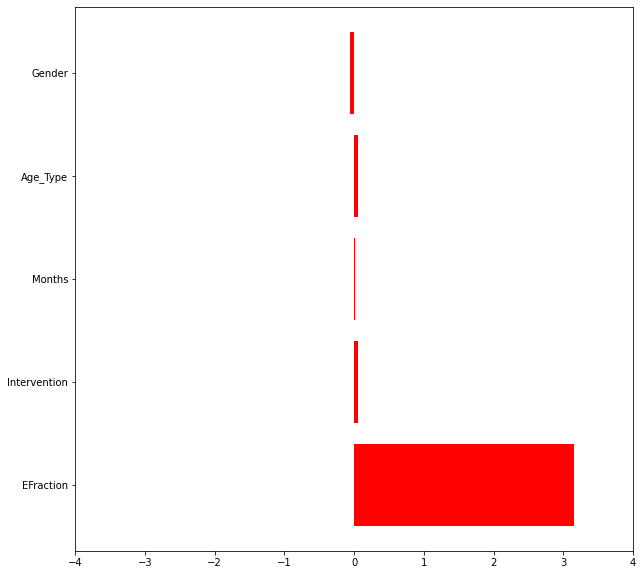

In [12]:
plt.rcParams["figure.figsize"]= (10,10)
plt.barh(X.columns, importance, color="r")
plt.xlim(-4,4)
plt.show()

In [13]:
countries_df = my_df[['Countries','Status']].copy()


def countries(data):
    for i in data['Countries'] :
        i = i.strip()
    return i
countries_df['Countries']= countries_df.apply(countries, axis=1)

c_df= (countries_df.set_index('Status')['Countries'].explode().rename('Country').groupby(level=0).value_counts().reset_index(name='count'))

In [16]:
c_df['Country'] = np.where(
    c_df['Country'] == 'United States', 
    'United States of America', 
    c_df['Country']
)

In [18]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# Merge the two DataFrames together
table = world.merge(c_df.loc[c_df['Status'] == 0], how="left", left_on=['name'], right_on=['Country'])

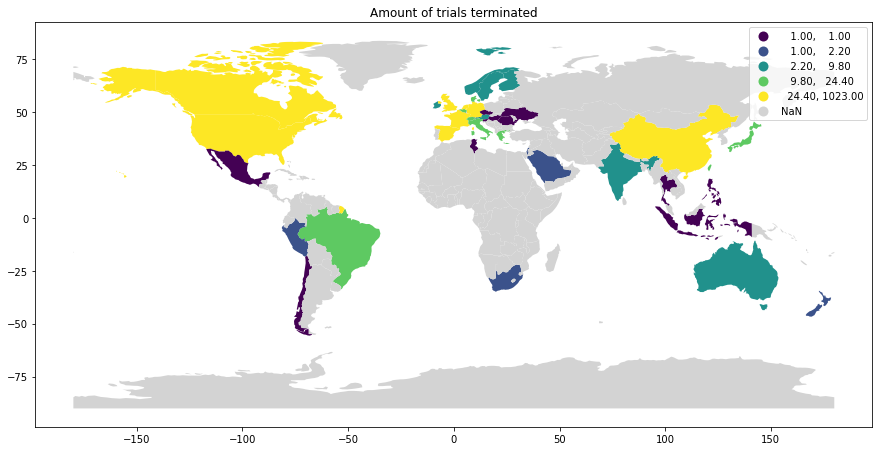

In [19]:
ax = table.plot(column='count', scheme="quantiles",
           figsize=(15,15),
           legend=True,cmap='viridis',  missing_kwds= dict(color = "lightgrey",))

ax.set_title("Amount of trials terminated")

## save fig
plt.savefig("terminated.png", dpi=200)